# Importing Necessary libraries and dataset


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from xgboost import XGBClassifier

In [118]:
#Importing the dataset

filepath = r"C:\Users\padma\Desktop\Computer_Science\al-ml\Datasets\train_loan.csv"

data = pd.read_csv(filepath)

data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Creating Necessary functions

In [119]:
def IQR(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3-q1
    upper_whisker = q3 + 1.5*iqr
    lower_whisker = q1 - 1.5*iqr

    return upper_whisker, lower_whisker


def classification_metrics(y_test,y_pred):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test,y_pred))
    print(f'Accuracy Score : {accuracy_score(y_test, y_pred)}')
    print(f'Precision Score : {precision_score(y_test, y_pred)}')
    print(f'Recall Score : {recall_score(y_test, y_pred)}')
    print(f'F1 Score : {f1_score(y_test, y_pred)}')


def plot_roc_curve(x_test,y_test,model):
    y_prob = model.predict_proba(x_test)[:,1]
    auc = roc_auc_score(y_test,y_prob)
    fpr,tpr, thresholds = roc_curve(y_test,y_prob)

    plt.plot(fpr,tpr,linewidth = 2,color ='green', label = f'ROC Curve with AUC = {auc}')
    plt.plot([0,1],[0,1], color = 'black', label = 'Random Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Data Preprocessing

## Analysing the data

In [120]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


5 numeric and rest all are categorical values

dependents column is numeric, but shown as object type

### Removing the loan id column

In [122]:
data = data.drop('Loan_ID', axis = 1)

### Checking for duplicates

In [123]:
data.duplicated().sum()

0

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


### Plotting graphs and other analysis

In [125]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


[]

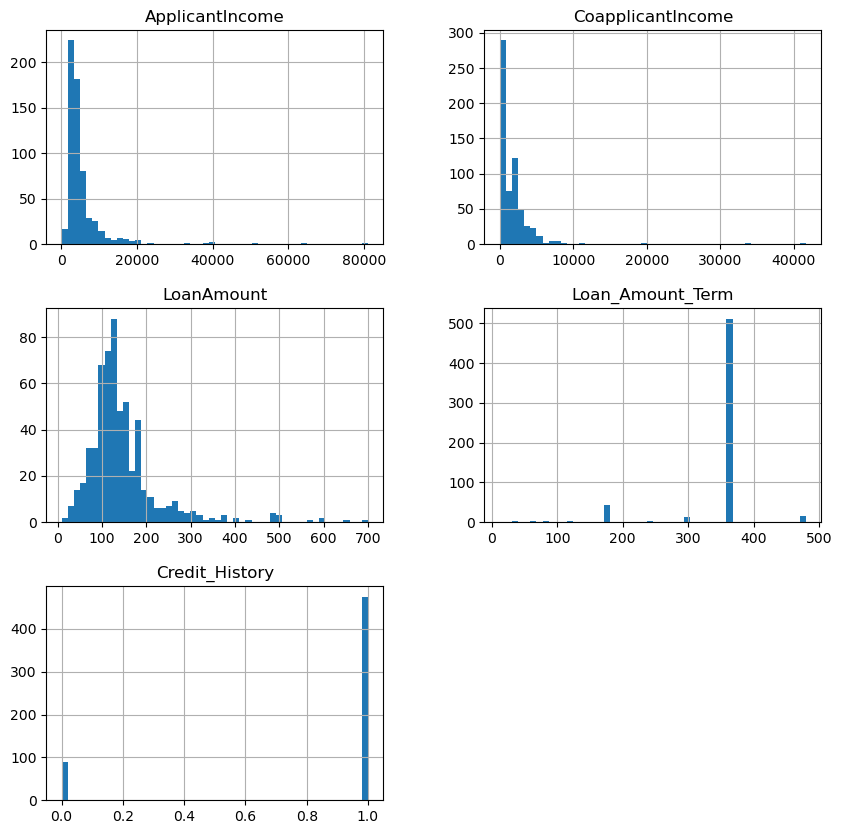

In [126]:
#Plotting histograms for all numeric columns
data.hist(figsize=(10,10), bins = 50)
plt.plot()

+ Applicant Income
  + The data ranges from 150 to 81000. Considering the Quartile values, most of the value represent a daily wage or the values may be in 100s or 1000s. 
    Still vales like 81000 doesnt make sense.Check for outliers

+ Coapplicant income
  +  The same problem with applicant income is there. Most of the values are less than 3000. Even if it is a daily wage or is in 100s or 1000s , still values like 40000 etc doesnt make sense. Check for outliers

+ Loan amount
  + The first to third quartiles are in the range of 100 - 200. The min value is 9 and max value 700.
  + since we dont know whether the value is in 1000s or 10000s , a proper outlier detection is not possible . So leaving it as it is

+ Loan Amount Term
  + All three quartiles showing 360 -- can be concluded that its value is in days.
  + so min vales like 12 doesnt fit. -- Check outliers

<Axes: >

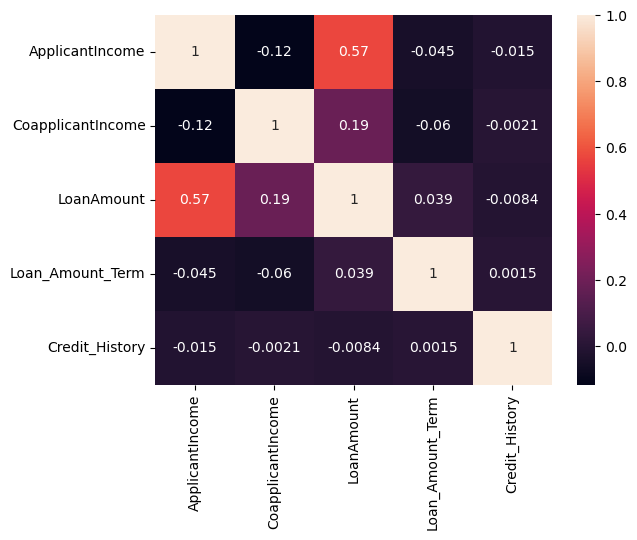

In [127]:
sns.heatmap(data.select_dtypes(exclude='object').corr(), annot = True)

#Loan amount and applicant income hace a corr >0.5 , rest all features have very less correlation.

## Outlier detection

### Applicant income

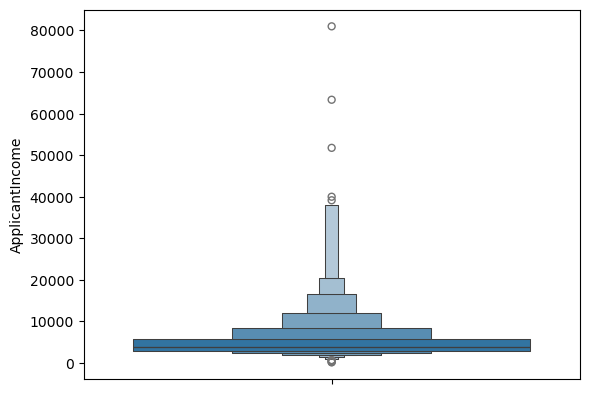

In [128]:
sns.boxenplot(data['ApplicantIncome'])
plt.show()

In [130]:

data[data['ApplicantIncome'] > 20000]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
126,NaN,Yes,3+,Graduate,No,23803,0.0,370.0,360.0,1.0,Rural,Y
130,Male,No,0,Graduate,Yes,20166,0.0,650.0,480.0,NaN,Urban,Y
155,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y
171,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
183,Male,Yes,1,Graduate,No,33846,0.0,260.0,360.0,1.0,Semiurban,N
185,Male,Yes,0,Graduate,Yes,39147,4750.0,120.0,360.0,1.0,Semiurban,Y
284,Male,Yes,0,Graduate,No,20667,0.0,NaN,360.0,1.0,Rural,N
308,Male,No,0,Graduate,No,20233,0.0,480.0,360.0,1.0,Rural,N
333,Male,Yes,0,Graduate,NaN,63337,0.0,490.0,180.0,1.0,Urban,Y
409,Male,Yes,3+,Graduate,No,81000,0.0,360.0,360.0,0.0,Rural,N


In [131]:
up,low = IQR(data['ApplicantIncome'])
up,low

(10171.25, -1498.75)

In [132]:
#Changing the extreme values to nan so that new values can be imputed using the imputer.
data.loc[data['ApplicantIncome'] > 25000, 'ApplicantIncome'] = np.nan

### Co applicant income

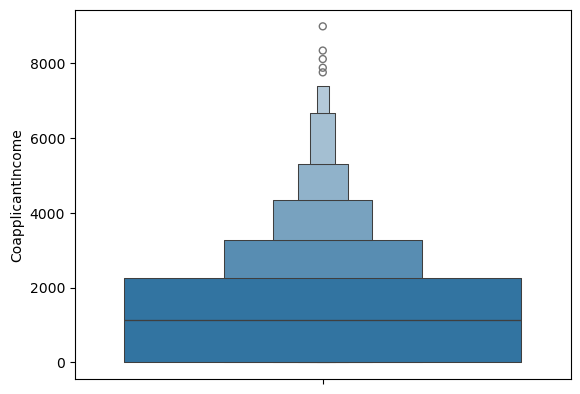

In [139]:
sns.boxenplot(data['CoapplicantIncome'])
plt.show()

In [140]:
IQR(data['CoapplicantIncome'])

(5626.875, -3376.125)

In [141]:
#Changing the extreme values to nan so that the imputer can impute a new value
data.loc[data['CoapplicantIncome'] > 10000, 'CoapplicantIncome'] = np.nan

### loan amount term

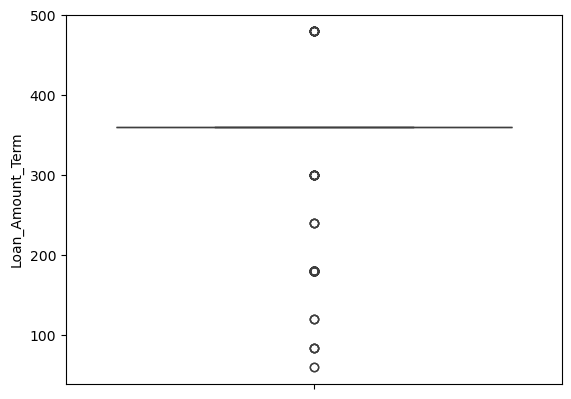

In [142]:
sns.boxplot(data['Loan_Amount_Term'])
plt.show()

In [143]:
IQR(data['Loan_Amount_Term'])

(360.0, 360.0)

In [144]:
#Changing the extreme values to the median value.
data.loc[data['Loan_Amount_Term'] < 60, 'Loan_Amount_Term'] = 360

## Handling missing values

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    607 non-null    float64
 6   CoapplicantIncome  608 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(5), object(7)
memory usage: 57.7+ KB


In [146]:
data.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       7
CoapplicantIncome     6
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [147]:
#numerical columns
for column in data.select_dtypes(exclude='object'):
    imputer = KNNImputer()
    data[column] = imputer.fit_transform(data[[column]])

    
#categorical columns
for column in data.select_dtypes(include='object'):
    data[column] = data[column].fillna(data[column].mode()[0])
         



In [148]:
data.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [149]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849.0,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000.0,0.0,141.000000,360.0,1.0,Urban,Y


## Encoding

In [150]:
#changing the dependents column 3+ values to numeric
data['Dependents'] = data['Dependents'].map({'0':0,'1':1,'2':2,'3+':3})

In [151]:
encoder = OrdinalEncoder(dtype= np.int64)
for column in data.select_dtypes(include= 'object'):
    data[column]= encoder.fit_transform(data[[column]])
                    

In [152]:
data.info()
#All columns have been changed to numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    int64  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    float64
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    int64  
 11  Loan_Status        614 non-null    int64  
dtypes: float64(5), int64(7)
memory usage: 57.7 KB


In [153]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849.0,0.0,146.412162,360.0,1.0,2,1
1,1,1,1,0,0,4583.0,1508.0,128.000000,360.0,1.0,0,0
2,1,1,0,0,1,3000.0,0.0,66.000000,360.0,1.0,2,1
3,1,1,0,1,0,2583.0,2358.0,120.000000,360.0,1.0,2,1
4,1,0,0,0,0,6000.0,0.0,141.000000,360.0,1.0,2,1


## Feature Target split

In [154]:
X = data.drop('Loan_Status', axis =1)
Y = data['Loan_Status']

## Train test split

In [155]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

## Scaling

In [156]:
sc = StandardScaler()
scaled_x_train = sc.fit_transform(x_train)
scaled_x_test = sc.transform(x_test)

# Random Forest Classification

In [157]:
classifier = RandomForestClassifier()
parameters = {
    'n_estimators' : [100, 20, 10, 200, 50],
    'criterion' : ['gini', 'entropy','log_loss'],
    'max_depth' : [None, 16,25,10,50,5],
    'n_jobs' : [2]
}
classifier_cv = GridSearchCV(classifier,param_grid=parameters, scoring= 'accuracy',n_jobs=2,
                             cv = 5)
classifier_cv.fit(x_train,y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 16, 25, 10, 50, 5],
                         'n_estimators': [100, 20, 10, 200, 50],
                         'n_jobs': [2]},
             scoring='accuracy')

In [158]:
classifier_cv.best_params_

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50, 'n_jobs': 2}

In [159]:
classifier = classifier_cv.best_estimator_
print(classifier_cv.best_score_)

y_pred = classifier.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))


0.8145949288806431
0.7886178861788617
0.7596153846153846


In [160]:
classification_metrics(y_test,y_pred)

Confusion Matrix:
[[18 25]
 [ 1 79]]
Accuracy Score : 0.7886178861788617
Precision Score : 0.7596153846153846
Recall Score : 0.9875
F1 Score : 0.8586956521739131


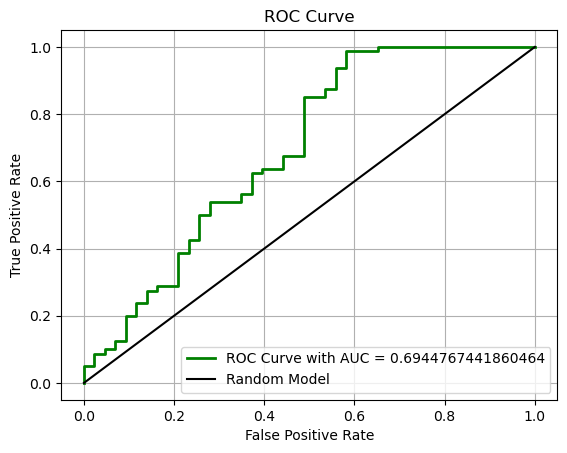

In [161]:
plot_roc_curve(x_test,y_test, classifier)

In [164]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(scaled_x_train,y_train)

y_pred = xgb.predict(scaled_x_test)

print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))



0.7560975609756098
0.7604166666666666


In [165]:
classification_metrics(y_test,y_pred)

Confusion Matrix:
[[20 23]
 [ 7 73]]
Accuracy Score : 0.7560975609756098
Precision Score : 0.7604166666666666
Recall Score : 0.9125
F1 Score : 0.8295454545454546


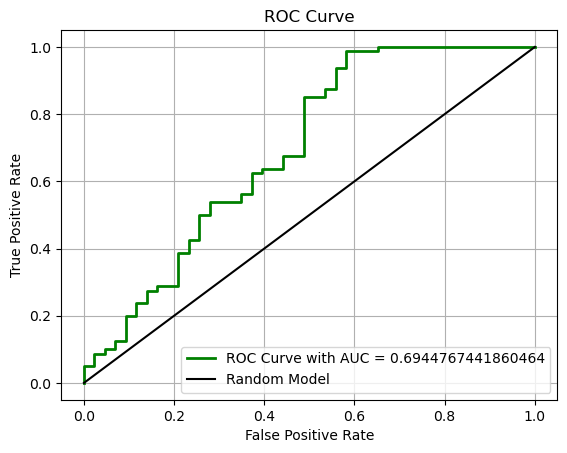

In [166]:
plot_roc_curve(x_test,y_test, classifier)

# AdaBoost Classifier

In [167]:
classifier = AdaBoostClassifier(algorithm='SAMME')
parameters = {
    'n_estimators' : [100, 20, 10, 200, 50,500],
    'learning_rate' : [0.1,0.5,0.6,1,0.7],
    'estimator' : [DecisionTreeClassifier(),LogisticRegression(),GaussianNB(), SVC()]
}
classifier_cv = GridSearchCV(classifier,param_grid=parameters, scoring= 'accuracy',n_jobs=2,
                             cv = 5)
classifier_cv.fit(scaled_x_train,y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(algorithm='SAMME'), n_jobs=2,
             param_grid={'estimator': [DecisionTreeClassifier(),
                                       LogisticRegression(), GaussianNB(),
                                       SVC()],
                         'learning_rate': [0.1, 0.5, 0.6, 1, 0.7],
                         'n_estimators': [100, 20, 10, 200, 50, 500]},
             scoring='accuracy')

In [168]:
classifier_cv.best_params_

{'estimator': LogisticRegression(), 'learning_rate': 0.7, 'n_estimators': 100}

In [169]:
classifier = classifier_cv.best_estimator_
print(classifier_cv.best_score_)

y_pred = classifier.predict(scaled_x_test)
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))


0.8125541125541126
0.7804878048780488
0.7572815533980582


In [170]:
classification_metrics(y_test,y_pred)

Confusion Matrix:
[[18 25]
 [ 2 78]]
Accuracy Score : 0.7804878048780488
Precision Score : 0.7572815533980582
Recall Score : 0.975
F1 Score : 0.8524590163934426


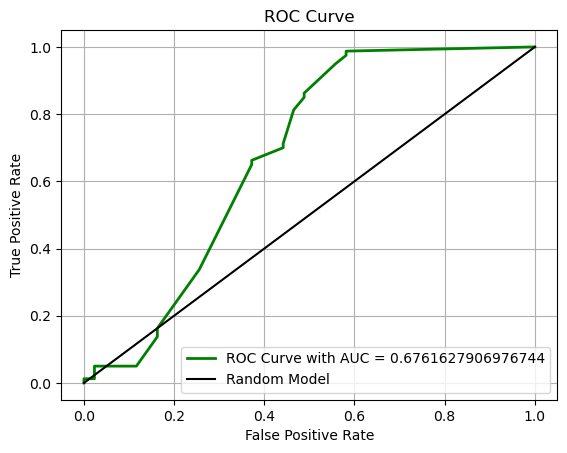

In [171]:
plot_roc_curve(scaled_x_test,y_test, classifier)

## Bagging Classifier

In [172]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

classifier = BaggingClassifier()
parameters = {
    'n_estimators' : [100, 20, 10, 200, 50],
    'estimator' : [LogisticRegression(), DecisionTreeClassifier(),SVC()],
    'max_features' : [1,2,3,4]
}
classifier_cv = GridSearchCV(classifier,param_grid=parameters, scoring= 'accuracy',n_jobs=2,
                             cv = 5)
classifier_cv.fit(scaled_x_train,y_train)

GridSearchCV(cv=5, estimator=BaggingClassifier(), n_jobs=2,
             param_grid={'estimator': [LogisticRegression(),
                                       DecisionTreeClassifier(), SVC()],
                         'max_features': [1, 2, 3, 4],
                         'n_estimators': [100, 20, 10, 200, 50]},
             scoring='accuracy')

In [173]:
classifier_cv.best_params_


{'estimator': DecisionTreeClassifier(), 'max_features': 4, 'n_estimators': 100}

In [174]:
classifier = classifier_cv.best_estimator_
print(classifier_cv.best_score_)

y_pred = classifier.predict(scaled_x_test)
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))

0.7739022881880024
0.7317073170731707
0.719626168224299


In [175]:
classification_metrics(y_test,y_pred)

Confusion Matrix:
[[13 30]
 [ 3 77]]
Accuracy Score : 0.7317073170731707
Precision Score : 0.719626168224299
Recall Score : 0.9625
F1 Score : 0.8235294117647058


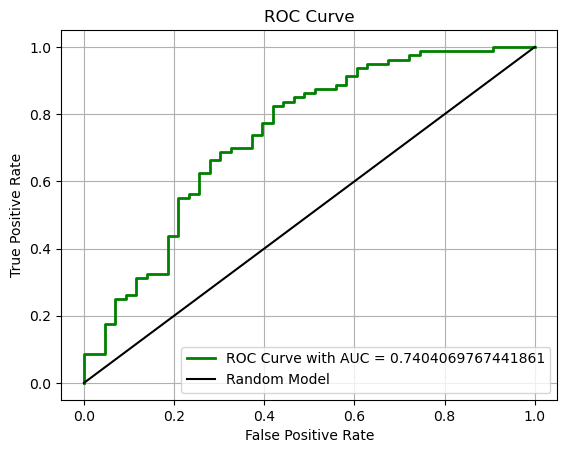

In [176]:
plot_roc_curve(scaled_x_test,y_test, classifier)

the roc curve of bagging classifier has more auc under it than the other models

In [ ]:
#Checking the performaace of a light model on the same dataset
nb = GaussianNB()
nb.fit(x_train,y_train)
y_pred1 =nb.predict(x_test)

classification_metrics(y_test,y_pred1)

Confusion Matrix:
[[18 25]
 [ 1 79]]
Accuracy Score : 0.7886178861788617
Precision Score : 0.7596153846153846
Recall Score : 0.9875
F1 Score : 0.8586956521739131


In [180]:
nb = DecisionTreeClassifier()
nb.fit(x_train,y_train)
y_pred1 =nb.predict(x_test)

classification_metrics(y_test,y_pred1)

Confusion Matrix:
[[21 22]
 [19 61]]
Accuracy Score : 0.6666666666666666
Precision Score : 0.7349397590361446
Recall Score : 0.7625
F1 Score : 0.7484662576687117


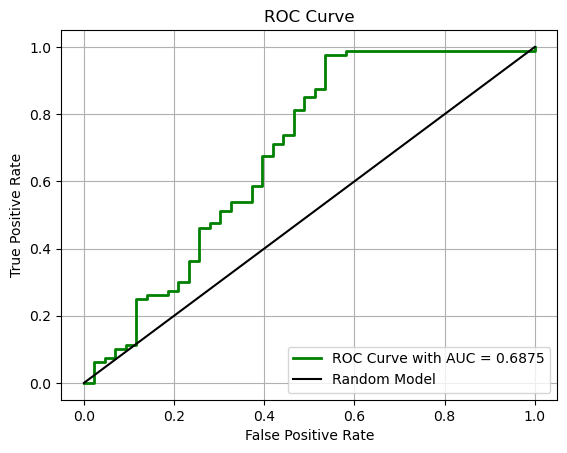

In [182]:
plot_roc_curve(x_test, y_test,nb)